# Importing Libreries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from time import time
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay


from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords
import re

# Load, preprocess and visualize data

In [2]:
# Read the CSV file containing steam reviews
df = pd.read_csv("steam_reviews.csv")

# Select relevant columns
df = df[['recommendation', 'review', 'title']]

# Create a new column 'class' based on the 'recommendation' values
df['class'] = df.recommendation.apply(lambda x: 0 if x=="Not Recommended" else 1)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 434891 entries, 0 to 434890
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   recommendation  434891 non-null  object
 1   review          433375 non-null  object
 2   title           434891 non-null  object
 3   class           434891 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 13.3+ MB


In [3]:
# Check for missing values in the DataFrame
print(df.isna().sum())

recommendation       0
review            1516
title                0
class                0
dtype: int64


In [4]:
# Drop rows with missing values from the DataFrame
df = df.dropna()

In [5]:
# Filter rows where the length of the review is between 50 and 120 characters
df = df[(df.review.apply(len)>50)&(df.review.apply(len)<120)]

In [6]:
# Calculate the number of reviews per 'title'
title_review_counts = df.groupby('title')['review'].count()

# Find 'title' groups with fewer than 29 reviews
titles_to_drop = title_review_counts[title_review_counts < 29].index

# Remove these 'title' groups from the DataFrame
data = df[~df['title'].isin(titles_to_drop)]

print(data)

       recommendation                                             review  \
7         Recommended  I have never been told to kill myself more tha...   
15        Recommended  I hope that one day all ppl who played it woul...   
21        Recommended  If you're against Generator abuse and want to ...   
30        Recommended  It isn't very horror and it is a very good gam...   
31        Recommended  Fun game to play with friends especially if yo...   
...               ...                                                ...   
434859    Recommended  This is my favorite game so far! Very dumb and...   
434865    Recommended  Very Groovy Game to Play with the Ladsyou hear...   
434869    Recommended  Product received for free. This is incredible!...   
434873    Recommended  I broke my mouse playing this game. 10/10 woul...   
434876    Recommended  great game although my its annoying when your ...   

                   title  class  
7       Dead by Daylight      1  
15      Dead by Day

<Axes: xlabel='review', ylabel='title'>

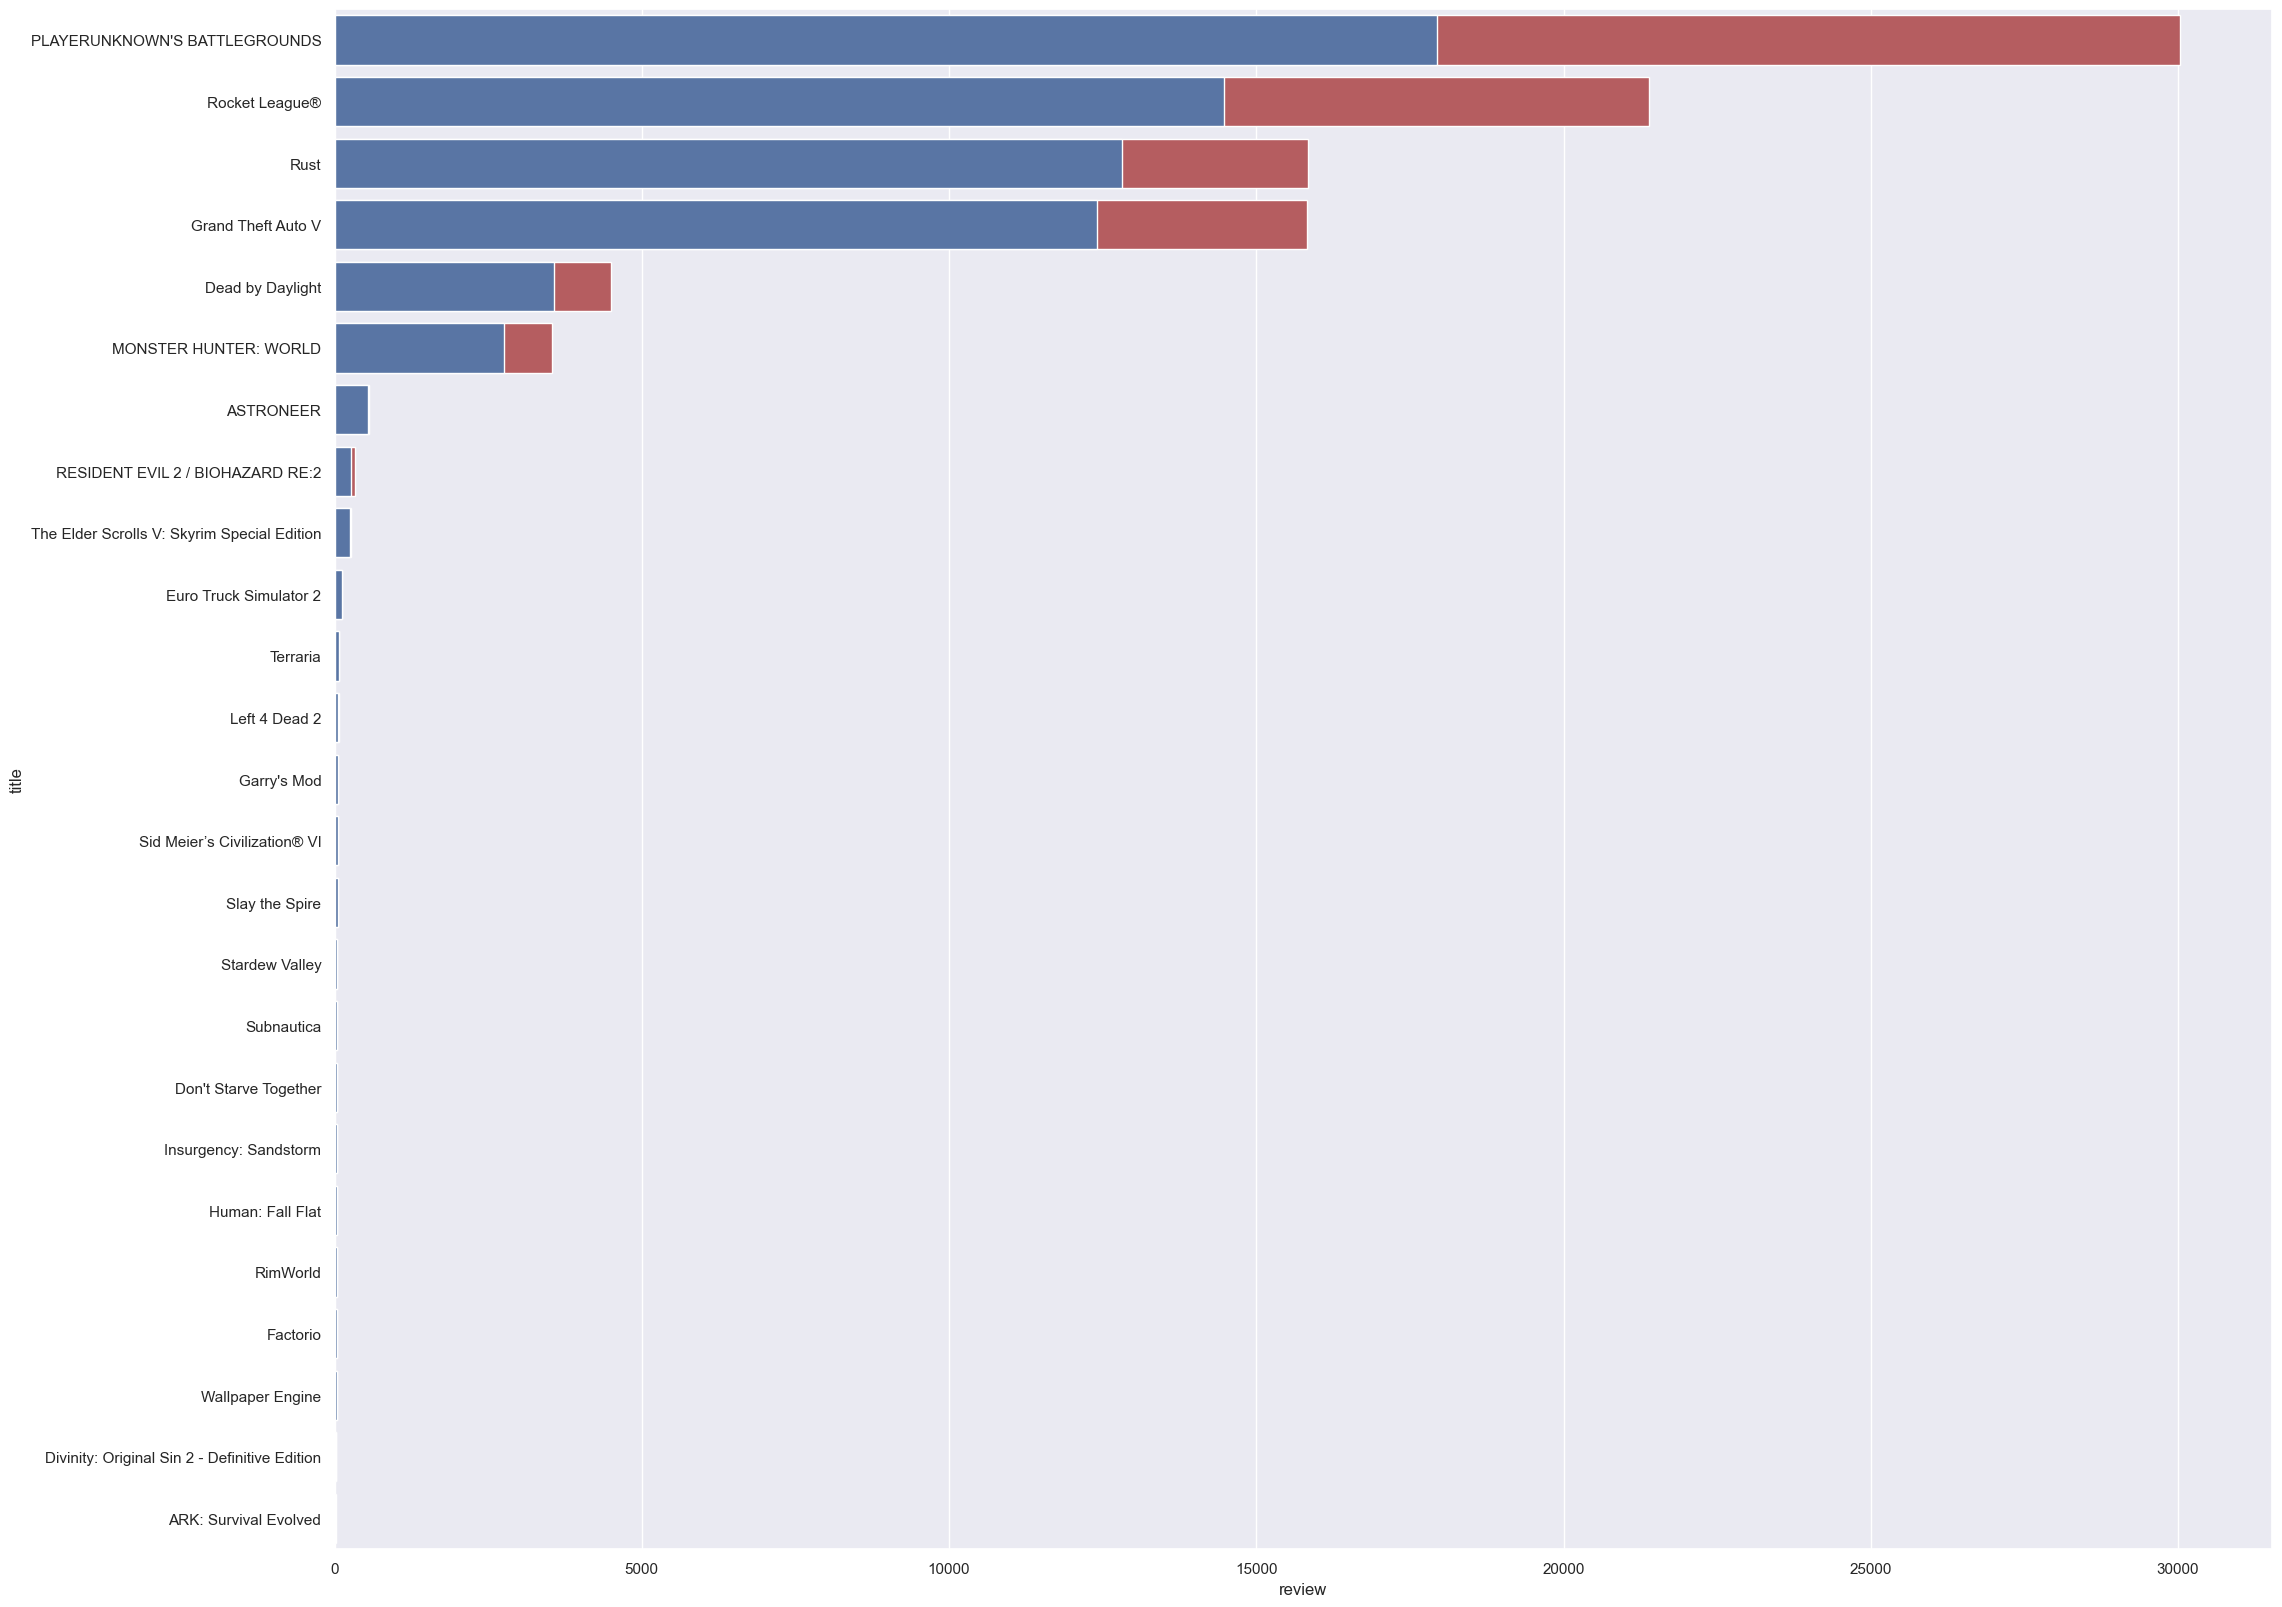

In [7]:
# Group the reviews by 'title' and visualize the total and positive reviews
reviews_count = data.groupby(['title'])['review'].count().sort_values(ascending=False)

reviews_count = reviews_count.reset_index()

sns.set(style="darkgrid")
plt.figure(figsize=(25,20))
sns.barplot(y=reviews_count['title'], x=reviews_count['review'], data=reviews_count,
            label="Total", color="r")

reviews_count_pos = data.groupby(['title', 'class'])['review'].count().sort_values(ascending=False)
reviews_count_pos = reviews_count_pos.reset_index()
reviews_count_pos = reviews_count_pos[reviews_count_pos['class'] == 1]
sns.barplot(y=reviews_count_pos['title'], x=reviews_count_pos['review'], data=reviews_count_pos,
            label="Total", color="b")

In [8]:
nltk.download('stopwords')

# Function to clean text by converting to lowercase and removing punctuation
def clean_text(text):
    text = text.lower()
    
    # Remove punctuation and special characters
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    
    return text

# Function to create a wordcloud from reviews in a specified DataFrame column
def create_review_wordcloud(df, column):
    stop_words = set(stopwords.words('english'))
    
    text = ' '.join(df[column].apply(clean_text))
    
    # Create a WordCloud
    wordcloud = WordCloud(
        width=800, 
        height=400, 
        background_color='white', 
        stopwords=stop_words,
        max_words=100,
        colormap='viridis'
    ).generate(text)
    
    # Visualize the WordCloud
    plt.figure(figsize=(10,5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title('Review Word Cloud')
    plt.tight_layout(pad=0)
    plt.show()


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\talha\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


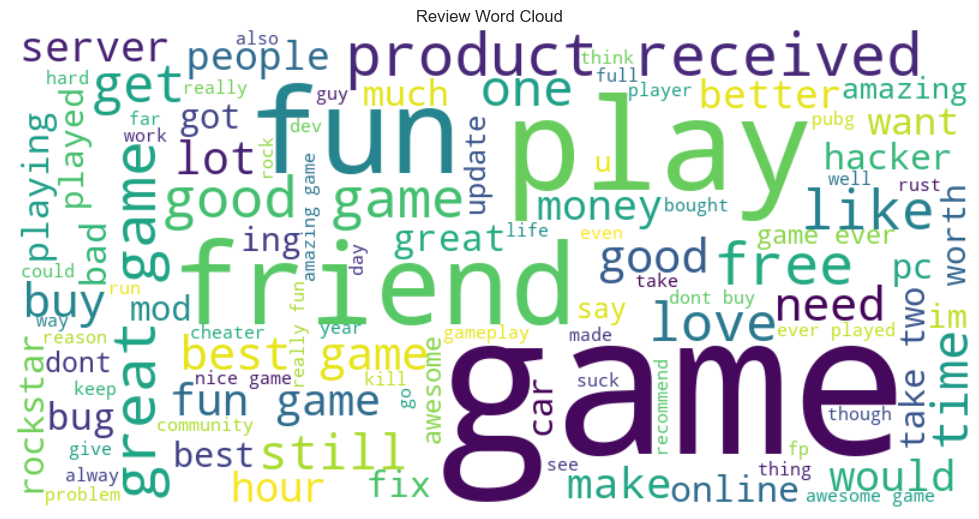

In [9]:
create_review_wordcloud(data, 'review')

In [10]:
# Splitting the dataset into training and testing sets

X = data['review']
y = data['class']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=23, stratify=y)

# Model training and evaluation

In [11]:
# Define a pipeline with TF-IDF vectorizer and Logistic Regression classifier
text_clf = Pipeline([
                     ('vect', TfidfVectorizer(max_df=0.99, norm='l2')),  # Convert text to TF-IDF features
                     ('clf', LogisticRegression(solver='saga', fit_intercept=True, class_weight='balanced'))  # Train a logistic regression classifier
                    ])

# Fit the model with the training data
text_clf.fit(X_train, y_train)

Pipeline(steps=[('vect', TfidfVectorizer(max_df=0.99)),
                ('clf',
                 LogisticRegression(class_weight='balanced', solver='saga'))])

In [12]:
# Predict the labels for the test set
y_pred = text_clf.predict(X_test)

# Evaluate the model using classification report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.71      0.85      0.78      8196
           1       0.93      0.86      0.89     19744

    accuracy                           0.86     27940
   macro avg       0.82      0.86      0.83     27940
weighted avg       0.87      0.86      0.86     27940



# Results

In [13]:
# Get the feature importance (coefficients) from the classifier
coef = text_clf.named_steps['clf'].coef_

# Get the feature names (words) from the vectorizer
features = text_clf.named_steps['vect'].get_feature_names_out()

# Sort the features by the highest positive coefficients (most influential positive words)
top_positive_features = np.argsort(coef[0])[-10:]  # Get top 10 most positive features
top_negative_features = np.argsort(coef[0])[:10]   # Get top 10 most negative features

# Print the top 10 most positive features (words with the highest positive coefficients)
print("Top 10 most positive words:")
for index in top_positive_features[::-1]:
    print(f"{features[index]}: {coef[0][index]}")

# Print the top 10 most negative features (words with the lowest coefficients)
print("\nTop 10 most negative words:")
for index in top_negative_features:
    print(f"{features[index]}: {coef[0][index]}")

Top 10 most positive words:
best: 8.548981672793065
great: 7.9684141452671
awesome: 7.963475318413673
amazing: 7.728407507507894
love: 6.890102764847866
good: 6.149077549436568
fun: 6.067061554963627
10: 5.143559722280866
addicting: 4.514934683139713
addictive: 4.447572657167939

Top 10 most negative words:
modding: -6.058139255688722
worst: -5.746535212776246
ruined: -5.643315521601823
not: -5.3719459965392184
refund: -5.144399657441867
unplayable: -5.062808956056463
garbage: -4.874193583051623
mods: -4.845924499809689
crashes: -4.705227802340645
trash: -4.589798971170557


In [14]:
print("Recommended" if (text_clf.predict(["WORST GAME EVER, I CAN NOT PLAY THIS GAME IT IS UNPLAYABLE"])[0]) else "Not Recommended")

Not Recommended


In [15]:
print("Recommended" if (text_clf.predict(["best game to buy and it is playable. i love this game it is not the worst game"])[0]) else "Not Recommended")

Recommended


In [16]:
print("Recommended" if (text_clf.predict(["not great and unplayable"])[0]) else "Not Recommended")

Not Recommended


In [17]:
def classification_results(y_test, y_pred):
    # Accuracy
    accuracy = accuracy_score(y_test, y_pred)
    
    # Precision
    precision = precision_score(y_test, y_pred)
    
    # Recall
    recall = recall_score(y_test, y_pred)
    
    # F1-Score
    f1 = f1_score(y_test, y_pred)
    
    print("Accuracy: {:.4f}".format(accuracy))
    print("Precision: {:.4f}".format(precision))
    print("Recall: {:.4f}".format(recall))
    print("F1-Score: {:.4f}".format(f1))
    
classification_results(y_test, y_pred)

Accuracy: 0.8552
Precision: 0.9342
Recall: 0.8552
F1-Score: 0.8930


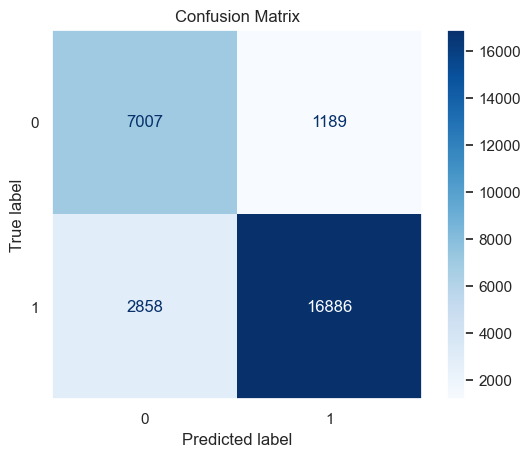

In [18]:
# Confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Visualize the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.grid(False)
plt.show()


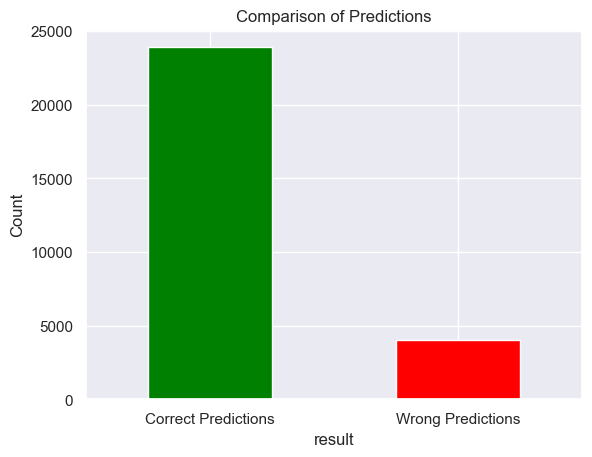

In [19]:
# Create a DataFrame to compare actual vs predicted values
comparison = pd.DataFrame({'y_test': y_test, 'y_pred': y_pred})
comparison['result'] = comparison['y_test'] == comparison['y_pred']

# Get value counts of correct and wrong predictions
result_counts = comparison['result'].value_counts()

# Ensure the order is correct: True first, then False
result_counts = result_counts.reindex([True, False])  

# Plot a bar chart for correct (green) and incorrect (red) predictions
result_counts.plot(kind='bar', color=['green', 'red']) 
plt.xticks(ticks=[0, 1], labels=['Correct Predictions', 'Wrong Predictions'], rotation=0)
plt.ylabel('Count')
plt.title('Comparison of Predictions')
plt.show()
